In [1]:
import os,sys
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np 
from scipy.spatial.distance import pdist
import time 
import math
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

Using TensorFlow backend.
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Qiqi/opt/anaconda3/lib/python3.7/site-pa

In [2]:
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam

In [3]:
# change the root to your own path 
root = sys.path[0]
train_dir =  os.path.join(root,  '../data/train_set')  
train_image_dir =  os.path.join(train_dir, 'images')
train_pt_dir =  os.path.join(train_dir, 'points' )
train_label_path =  os.path.join(train_dir,  "label.csv") 

In [4]:
info = pd.read_csv(train_label_path)
train_idx, test_idx = train_test_split(info['Index'], test_size=0.2, random_state=123)

# read mat file and store coordinates in mat 
m = []
for idx in info['Index']: 
    file = "%04d.mat"%(idx)
    m.append( scipy.io.loadmat( os.path.join( train_pt_dir, file ) ))

mat = [x[[i for i in x.keys() if not i in ['__header__', '__version__', '__globals__']][0]] for x in m]

###  train test split

In [5]:
train_idx, test_idx = train_test_split(info['Index'], test_size=0.2, random_state=123)

In [16]:
train_mat = [ mat[i-1] for i in train_idx ] 
test_mat = [ mat[i-1] for i in test_idx ] 

In [22]:
train_labels = info.emotion_idx[train_idx-1]
test_labels = info.emotion_idx[test_idx-1]

In [29]:
train_label_cat = to_categorical(train_labels)
train_label_cat= train_label_cat[:,1:]
test_label_cat = to_categorical(test_labels)
test_label_cat= test_label_cat[:,1:]

### feature extraction  

In [18]:
# method 1：  pairwise_dist_cal  
#def pairwise_dist_cal(xy_cord):
    #p_dist =[]
    #for i in range(xy_cord.shape[0]):
        #for j in range(i+1,xy_cord.shape[0]):
               # p_dist.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
               # p_dist.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
    #return p_dist 



#### updated methods with selected fiducial points; this reduce 78 poins to 50  
''' 
feature selection : 1. remove  points P64 - 70 and P72 - 78  
                 2. remove P51,53,55,57,58,60, 61, 63
                 3. calculate midpints between  upper and lower eyebrow lines and replace P20-22,P24-16 with midpoints               
So there is in total 50 points left, which gives 50*49 pairwise distance 
'''

def pairwise_dist_cal_updt(mt):
    t0 = time.time()
    p_dist_updt =np.zeros([len(mt),1225,2])
    n = len(mt)
    for k in range(n):
        xy_cord = mt[k]

        xy_cord_cpy  = xy_cord
        
        #  eye_brow midpoint 
        to_add_brl = (xy_cord_cpy[19:22]+ xy_cord_cpy[23:26])/2
        to_add_brr = (xy_cord_cpy[27:30]+ xy_cord_cpy[31:34])/2

        # index to remove 
        rm_idx = np.append(np.arange(63,70), np.arange(71,78))
        rm_idx = np.append(rm_idx,np.arange(50,57,2) )
        rm_idx = np.append(rm_idx, [57,59,60,62])
        rm_idx = np.append(rm_idx, np.arange(19,22))
        rm_idx = np.append(rm_idx, np.arange(23,26))
        rm_idx = np.append(rm_idx, np.arange(27,30))
        rm_idx = np.append(rm_idx, np.arange(31,34))
        xy_cord = np.delete(xy_cord, rm_idx, axis = 0) 
        xy_cord = np.concatenate((xy_cord,to_add_brl,to_add_brr))
        

        dist_h = [] 
        dist_v = []
        for i in range(xy_cord.shape[0]):
            for j in range(i+1,xy_cord.shape[0]):
                dist_h.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
                dist_v.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
        p_dist_updt[k,:,0]= dist_h
        p_dist_updt[k,:,1]= dist_v
    

    print("feature constructions takes %s seconds" % (time.time() - t0))
    return p_dist_updt.reshape([n,2450])


In [19]:
print("training: ")
train_data = pairwise_dist_cal_updt(train_mat[0:])

training: 
training and testing feature constructions 18.035425901412964 seconds


In [21]:
print("testing: ")
test_data = pairwise_dist_cal_updt(test_mat[0:])

testing: 
training and testing feature constructions 4.777792930603027 seconds


In [ ]:
accuracy_score(pred_xgb_2,test_labels_xgb )

# XGB model 

In [55]:
from xgboost.sklearn import XGBClassifier

In [58]:
train_labels_xgb = [ x  - 1 for x in train_labels ] 
test_labels_xgb = [ x  - 1 for x in test_labels ] 

In [60]:
start_time=time.time()

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators= 200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',  # for multi-labels classification 
 num_class = 22, 
 scale_pos_weight=1,
 seed=123)

xgb.fit(train_data, train_labels_xgb ,eval_metric='auc')
print("training  model takes %s seconds" % round((time.time() - start_time),3))

training  model takes 1074.819 seconds


In [65]:
start_time = time.time()
pred_xgb = xgb.predict(test_data)
print("testing model takes %s seconds" % round((time.time() - start_time),3))

testing model takes 0.71 seconds


In [68]:
acc_xgb = accuracy_score(pred_xgb,test_labels_xgb )
print("Test accuracy is %s percent" %(acc_xgb*100))

Test accuracy is 47.4 percent


Try other leaner rate and n_trees

In [96]:
xgb_2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators= 500,
 max_depth= 3 ,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',  # for multi-labels classification 
 num_class = 22, 
 scale_pos_weight=1,
 seed=123)

In [97]:
xgb_2.fit(train_data, train_labels_xgb ,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, num_class=22, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=123, silent=None, subsample=0.8, verbosity=1)

In [100]:
start_time = time.time()
pred_xgb_2 = xgb_2.predict(test_data)
print("testing model takes %s seconds" % round((time.time() - start_time),3))


testing model takes 1.546 seconds


In [102]:
acc_sc = accuracy_score(pred_xgb_2,test_labels_xgb )
print("Test accuracy is %s percent" %(acc_sc *100))


Test accuracy is 49.2 percent


# CNN model 

In [32]:
X = train_data
Y = train_label_cat

In [33]:
input_shape = [2450] 
input_layer = Input(input_shape)
x = BatchNormalization()(input_layer) 
x = Dense(22*20,activation='relu',kernel_initializer=initializers.glorot_normal(seed=None))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=None))(x)
x = Dropout(0.25)(x)
x = Dense(22*6,activation='relu',kernel_initializer=initializers.glorot_normal(seed=None))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=None))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=None))(x) 
model = Model(input_layer,output_layer)


Epoch 1/100
2000/2000 [==============================] - 3s 2ms/step - loss: 2.9830 - accuracy: 0.1120
Epoch 2/100
2000/2000 [==============================] - 2s 851us/step - loss: 2.5688 - accuracy: 0.1970
Epoch 3/100
2000/2000 [==============================] - 2s 850us/step - loss: 2.2683 - accuracy: 0.2710
Epoch 4/100
2000/2000 [==============================] - 2s 1ms/step - loss: 2.1527 - accuracy: 0.2925
Epoch 5/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.9536 - accuracy: 0.3700
Epoch 6/100
2000/2000 [==============================] - 2s 941us/step - loss: 1.8609 - accuracy: 0.3825
Epoch 7/100
2000/2000 [==============================] - 2s 1ms/step - loss: 1.7398 - accuracy: 0.4190
Epoch 8/100
2000/2000 [==============================] - 3s 1ms/step - loss: 1.6755 - accuracy: 0.4515
Epoch 9/100
2000/2000 [==============================] - 3s 1ms/step - loss: 1.5764 - accuracy: 0.4630
Epoch 10/100
2000/2000 [==============================] - 3s 1ms/s

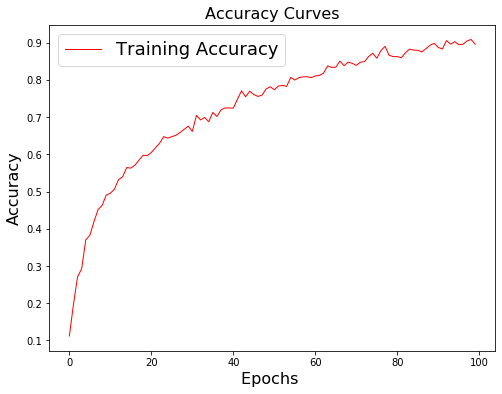

In [34]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_his = model.fit(X,Y,epochs=100)
plt.figure(figsize=[8,6])
plt.plot(model_his.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
print('lr=0.0001, train complete')
print("training  model takes %s seconds" % round((time.time() - start_time),3))

In [56]:
t0 = time.time()
pred = model.predict(test_data)
pred_lst = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_lst.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)
acc = accuracy_score(pred_lst, tst_labl)
print("Test accuracy is %s percent" %(acc*100))
print("testing model takes %s seconds" % round((time.time() - t0),3))

Test accuracy is 54.0 percent
testing model takes 0.089 seconds
